In [1]:
import pathlib
from pathlib import Path
import os
from collections import defaultdict
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
plt.style.use('ggplot')

# Utils

In [20]:
def read_image(path: str):
    im = Image.open(path)
    return np.array(im)

def plot_image(img: np.ndarray, ax: matplotlib.axes.Axes):
    ax.imshow(img)
    
def get_image_dic(path: pathlib.PurePath):
    rec_dd = lambda: defaultdict(rec_dd)
    image_dic = defaultdict(rec_dd)
    for dataset in path.iterdir():
        splits_dir = [dir for dir in dataset.iterdir() if dir.stem != 'ignore' ]
        for split in splits_dir:
            for class_ in split.iterdir():
                images = []
                for ext in ['png', 'tif', 'jpg', 'JPG', 'jpeg']:
                    images += list(class_.glob(f'**/*.{ext}'))
                for image in images:
                    image_dic[dataset.stem][split.stem][class_.stem][image]
    return image_dic
                    
def plot_images(images_per_row: int,
                image_dic: defaultdict,
                split: str):
    for dataset in image_dic:
        fig=plt.figure(figsize=(20, 4))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, n_images),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
        i = 0
        n_classes = len(image_dic[dataset][split])
        n_images_per_class = int(n_images/n_classes)
        for class_ in image_dic[dataset][split]:
            imgs_paths = list(image_dic[dataset][split][class_].keys())[:n_images_per_class]
            for img_path in imgs_paths:
                img = read_image(img_path)
                ax = grid[i]
                plot_image(img, ax)
                i += 1
                ax.axis('off')
                ax.set_title(class_)
        while i < images_per_row:
            ax = grid[i]
            ax.axis('off')
            i += 1
        fig.suptitle(dataset, fontweight='bold')

def make_class_histo(image_dic: defaultdict,
                     split: str):
    i = 1
    fig=plt.figure(figsize=(20,5))
    n_dataset = len(image_dic)
    for dataset in image_dic:
        semantic_classes = []
        samples_per_class = []
        for class_ in image_dic[dataset][split]:
            semantic_classes.append(class_)
            samples_per_class.append(len(image_dic[dataset][split][class_]))
        ax = plt.subplot(eval(f'1{n_dataset}{i}'))
        x = range(len(samples_per_class))
        
        # use a gray background
        ax.set_facecolor('#E6E6E6')
        ax.set_axisbelow(True)

        # draw solid white grid lines
        plt.grid(color='w', linestyle='solid')
        ax.bar(x, height=samples_per_class, width=0.2, color='#EE6666')
        ax.set_xticks(x)
        ax.set_xticklabels(semantic_classes)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(dataset, fontweight='bold')
        i += 1
        
def make_color_histo(image_dic: defaultdict,
                     split: str):
    for dataset in image_dic:
        fig=plt.figure(figsize=(20,5))
        i = 1
        n_classes = len(image_dic[dataset][split])
        n_images_per_class = int(n_images/n_classes)
        for class_ in image_dic[dataset][split]:
            imgs_paths= image_dic[dataset][split][class_]
            imgs = len(imgs_paths)
            imgs_from_cls = []
            for j, img_path in enumerate(imgs_paths):
                img = read_image(img_path)
                imgs_from_cls.append(np.expand_dims(img, 0))
                if j>= 100:
                    break
            min_h = min([x.shape[0] for x in imgs_from_cls])
            min_w = min([x.shape[1] for x in imgs_from_cls])

            imgs_from_cls = [x[:, :min_h, :min_w, :] for x in imgs_from_cls]
            all_imgs = np.concatenate(imgs_from_cls, 0)
            ax = plt.subplot(eval(f'1{n_classes}{i}'))
            ax.hist(all_imgs[..., 0].flatten(), bins=255, alpha=0.4)
            ax.hist(all_imgs[..., 1].flatten(), bins=255, alpha=0.4)
            ax.hist(all_imgs[..., 2].flatten(), bins=255, alpha=0.4)
            ax.set_title(class_)
            i += 1
        fig.suptitle(dataset, fontweight='bold')

def plot_general_info(image_dic: defaultdict,
                      split: str):
    for dataset in image_dic:
        fig=plt.figure(figsize=(20,5))
        i = 1
        info_dic = defaultdict(lambda : defaultdict(int))
        info_dic['byte_size'] = []
        for class_ in image_dic[dataset][split]:
            imgs_paths= image_dic[dataset][split][class_]
            for j, img_path in enumerate(imgs_paths):
                p = Path(img_path)
                info_dic['byte_size'].append(p.stat().st_size)
                img = read_image(img_path)
                info_dic['image_size'][img.shape[:2]] += 1
                if j>= 100:
                    break
        byte_sizes_counts = info_dic['byte_size']
        ax = plt.subplot(121)
        ax.boxplot(np.array(byte_sizes_counts) / 10**6)
        ax.set_title('Size (in MBytes)')
        
        all_img_sizes = list(info_dic['image_size'].keys())
        img_sizes_counts = list(info_dic['image_size'].values())
        ax = plt.subplot(122)
        x = range(len(all_img_sizes))
        ax.bar(x, img_sizes_counts)
        ax.set_xticks(x)
        ax.set_xticklabels(all_img_sizes)
        ax.set_title('Image sizes')
        
        
        i += 1
        fig.suptitle(dataset, fontweight='bold')

# Breast cancer

In [21]:
p = Path('data/Breast cancer')
breast_image_dic = get_image_dic(p)

In [22]:
a = list(breast_image_dic['breakhis']['training']['benign'].keys())[0]

In [28]:
a.parts[-4]

'fibroadenoma'

#### General info

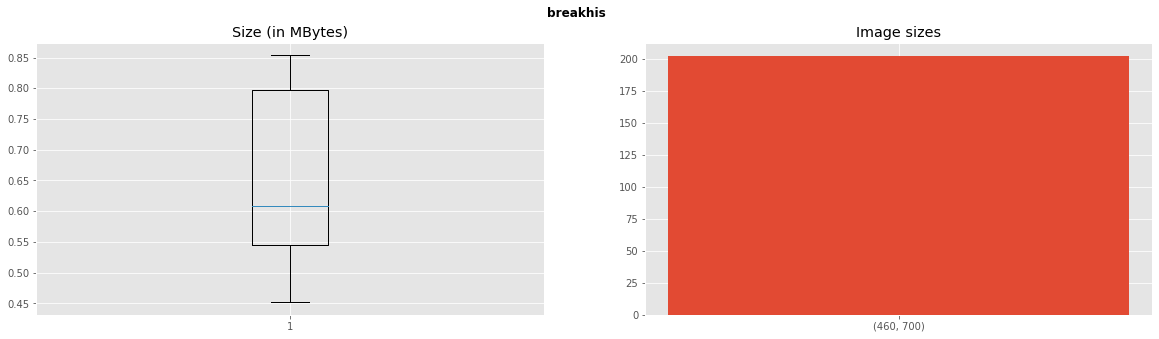

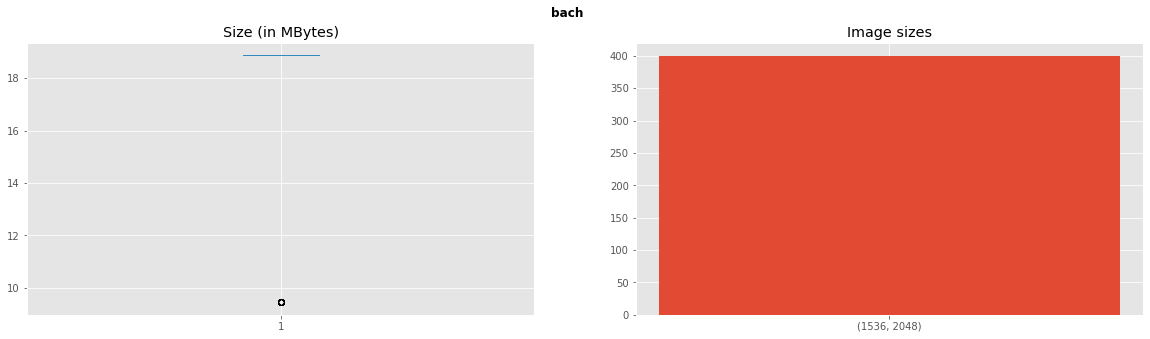

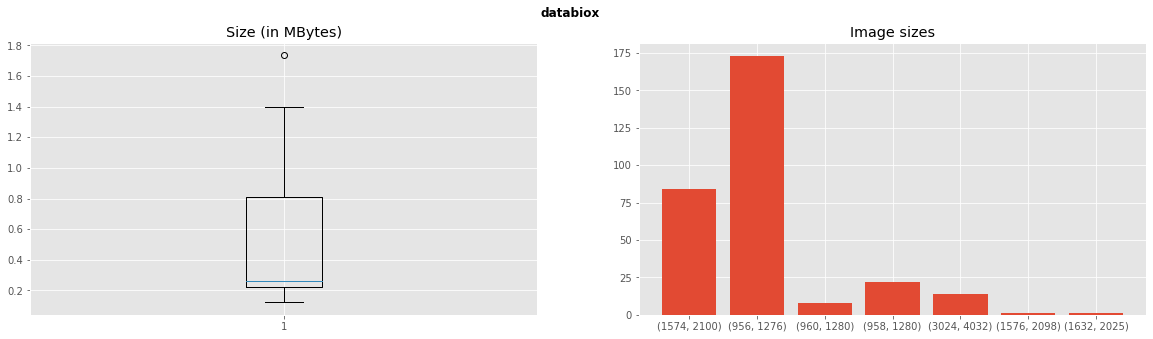

In [4]:
plot_general_info(breast_image_dic, 'training')

#### Plot some images

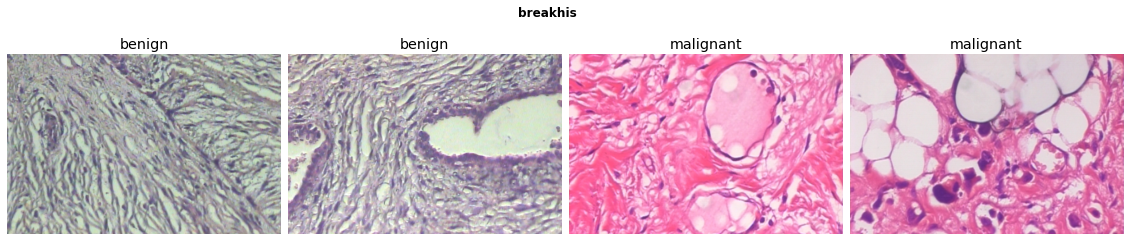

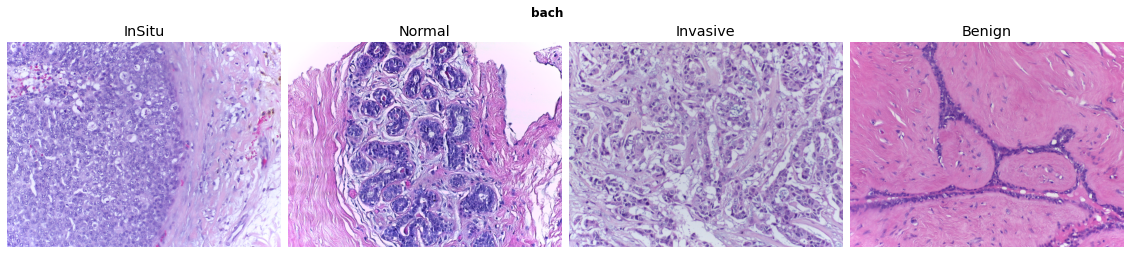

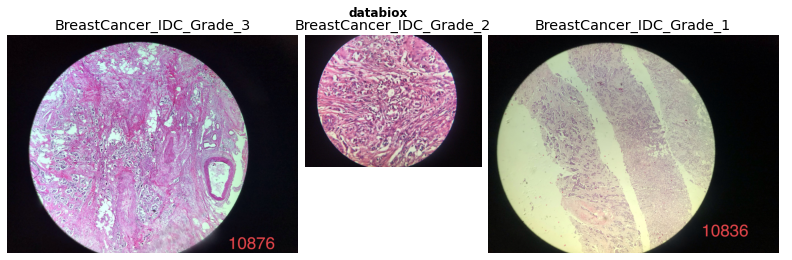

In [5]:
n_images = 4
split = 'training' # testing
plot_images(n_images,
            breast_image_dic,
            split)

#### Class balance

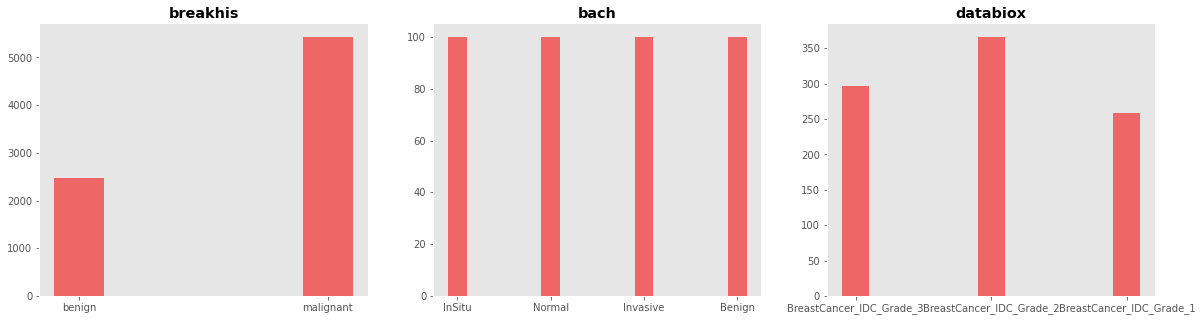

In [19]:
split = 'training' # testing
make_class_histo(breast_image_dic, split)

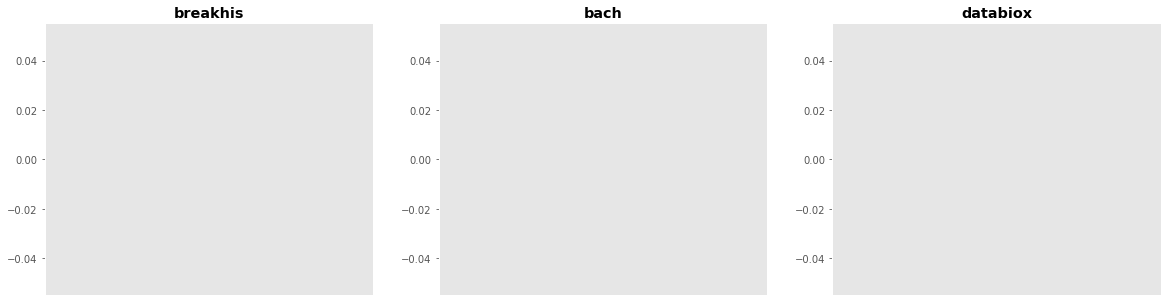

In [33]:
split = 'testing' # testing
make_class_histo(breast_image_dic,
                 split)

#### Classwise color histograms

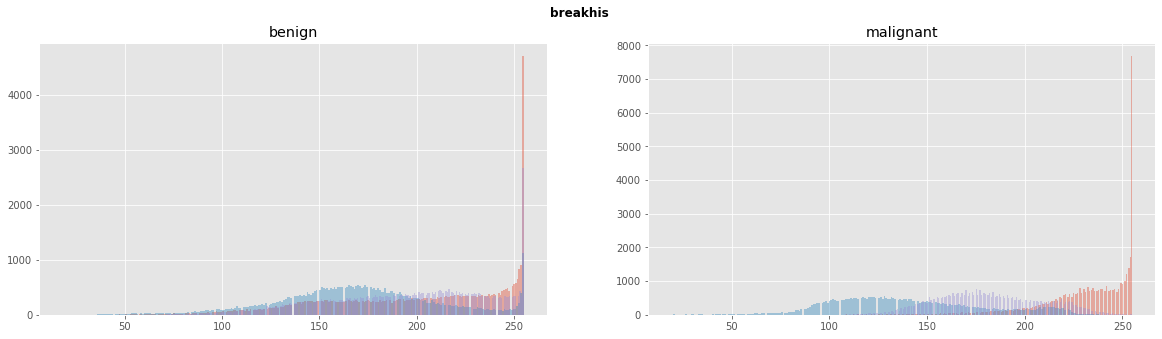

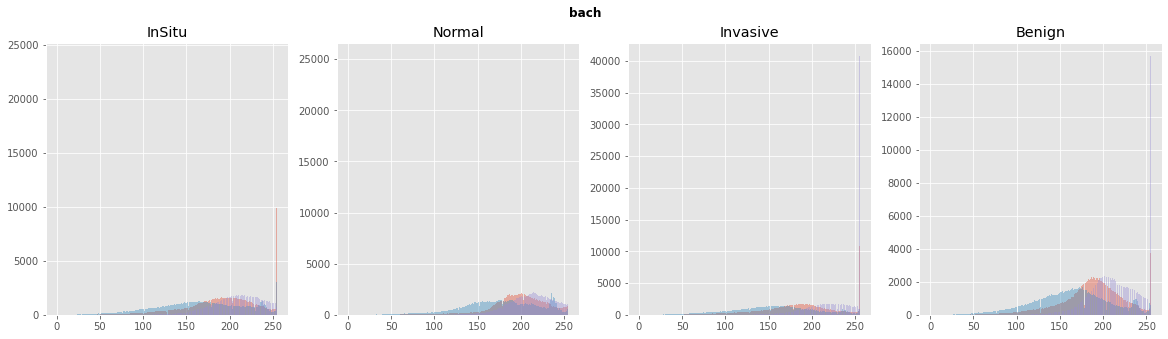

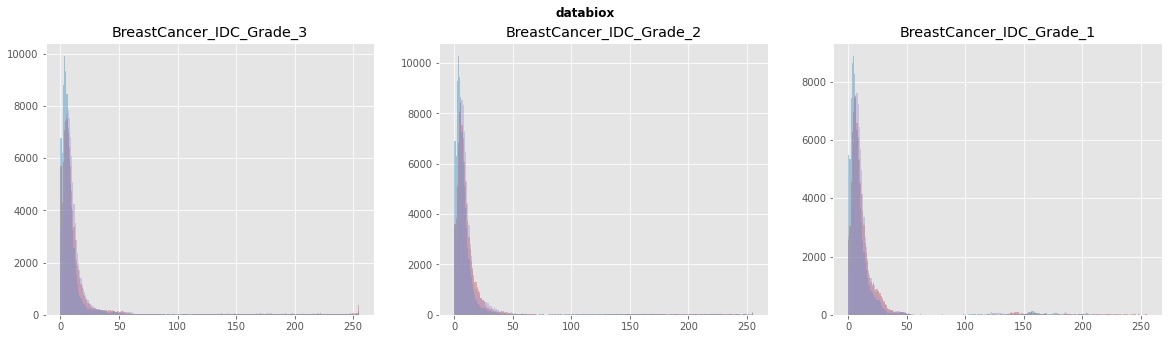

In [20]:
split = 'training' # testing
make_color_histo(breast_image_dic,
                 split)

# Colorectal cancer 

In [6]:
q = Path('./Colorectal cancer')
crc_image_dic = get_image_dic(q)

#### General info

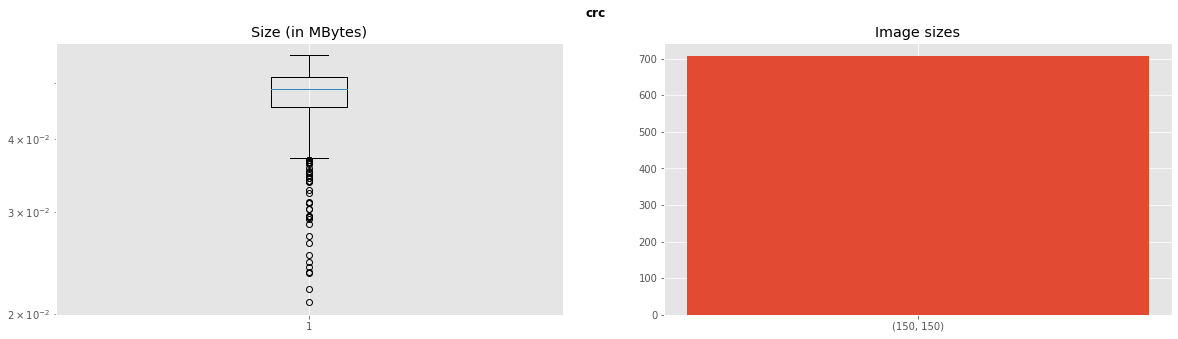

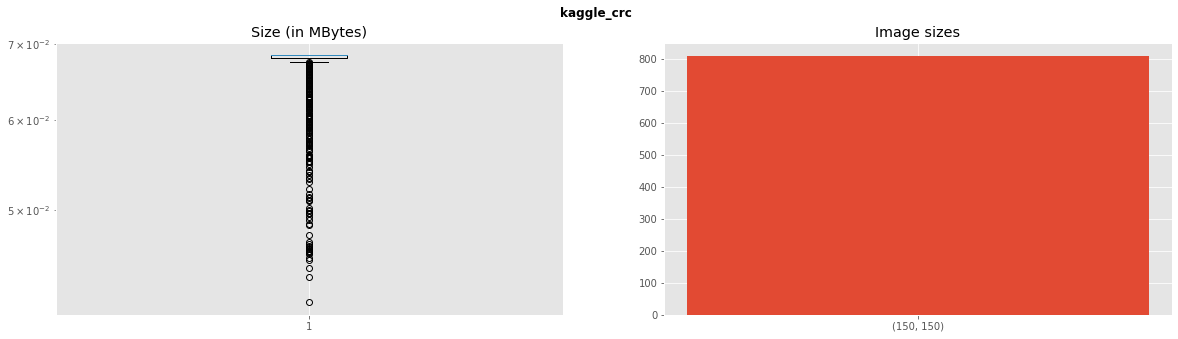

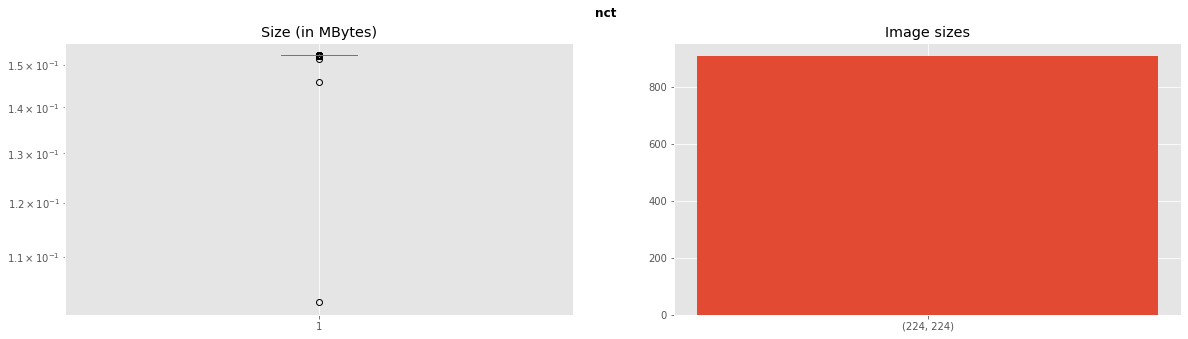

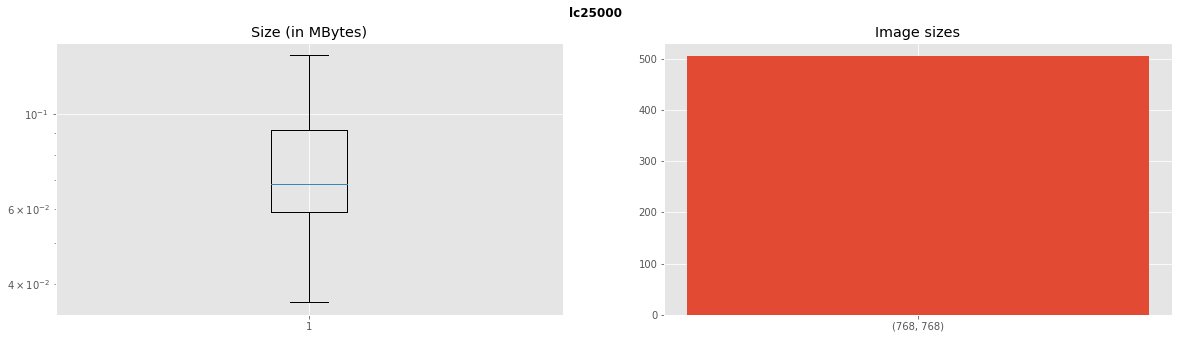

In [56]:
plot_general_info(crc_image_dic, 'training')

#### Plot some images

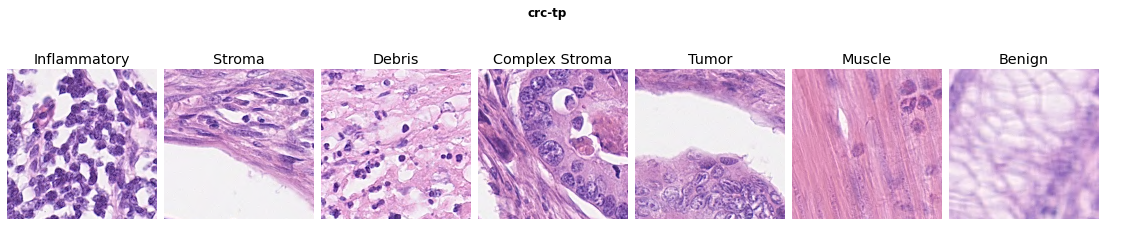

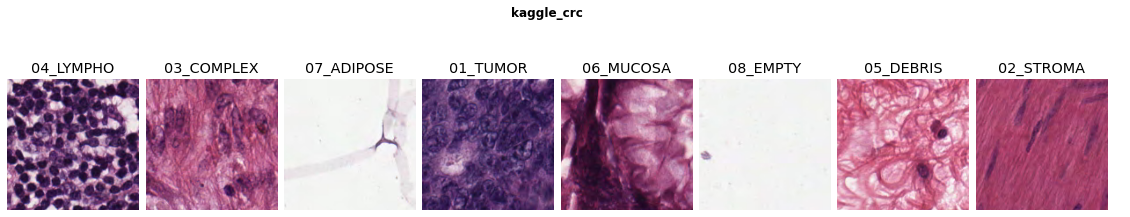

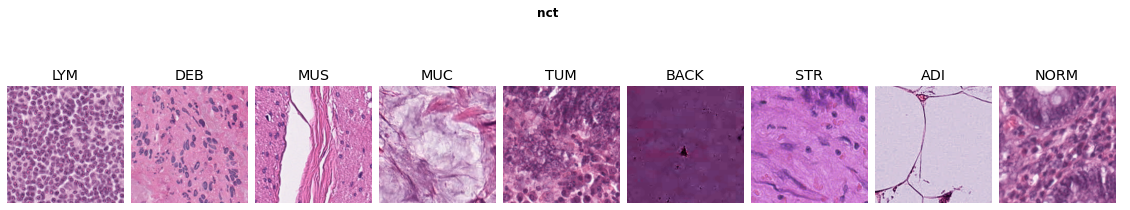

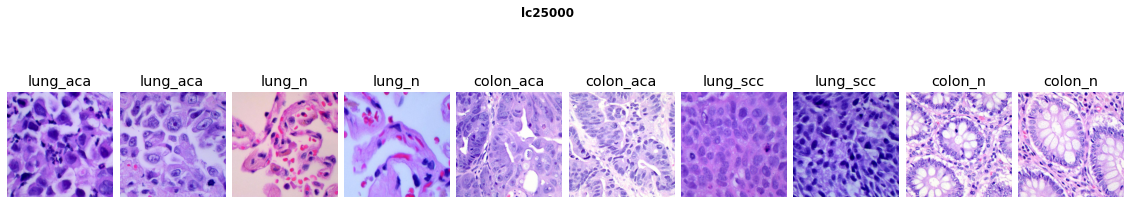

In [7]:
n_images = 10
split = 'training' # testing
plot_images(n_images,
            crc_image_dic,
            split)

#### Class balance

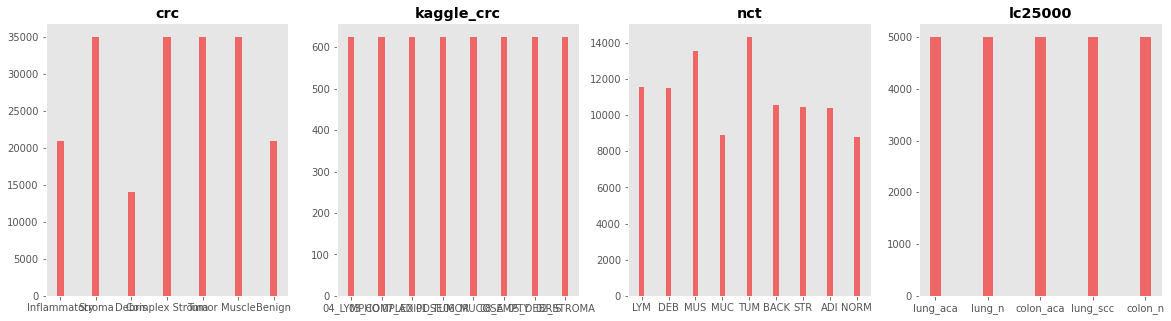

In [31]:
split = 'training' # testing|
make_class_histo(crc_image_dic,
                 split)

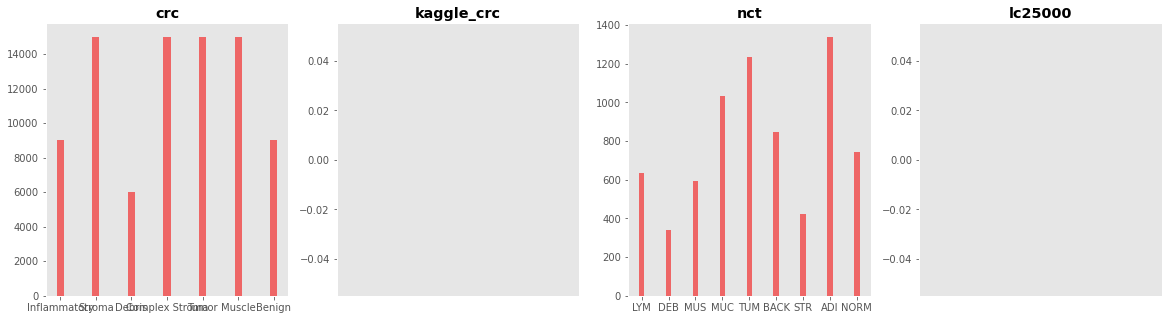

In [32]:
split = 'testing' # testing
make_class_histo(crc_image_dic,
                 split)